In [63]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import datetime

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot

from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from pandas import read_csv


In [64]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [65]:
# load dataset
dataset = read_csv('csv files/XAU_USD.csv', header=0, index_col=0)
dataset = dataset.drop(['Hac.', 'Fark %'], axis=1)

dataset['Şimdi'] = dataset['Şimdi'].apply(
    lambda x: float(x.split()[0].replace(',', '')))

dataset['Açılış'] = dataset['Açılış'].apply(
    lambda x: float(x.split()[0].replace(',', '')))

dataset['Yüksek'] = dataset['Yüksek'].apply(
    lambda x: float(x.split()[0].replace(',', '')))

dataset['Düşük'] = dataset['Düşük'].apply(
    lambda x: float(x.split()[0].replace(',', '')))


dataset.info()


<class 'pandas.core.frame.DataFrame'>
Index: 2865 entries, 30.12.2022 to 02.01.2012
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Şimdi   2865 non-null   float64
 1   Açılış  2865 non-null   float64
 2   Yüksek  2865 non-null   float64
 3   Düşük   2865 non-null   float64
dtypes: float64(4)
memory usage: 111.9+ KB


In [66]:
dataset.head(10)

,Şimdi,Açılış,Yüksek,Düşük
Tarih,,,,
30.12.2022,1.82440,1.81514,1.82673,1.80984
29.12.2022,1.81489,1.80416,1.82052,1.80202
28.12.2022,1.80409,1.81400,1.81518,1.79656
27.12.2022,1.81393,1.79667,1.83339,1.79620
26.12.2022,1.79761,1.79857,1.79878,1.79804
23.12.2022,1.79791,1.79265,1.80360,1.78962
22.12.2022,1.79257,1.81420,1.82110,1.78411
21.12.2022,1.81413,1.81806,1.82439,1.81124
20.12.2022,1.81741,1.78749,1.82160,1.78421


In [67]:
values = dataset.values
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(
	reframed.columns[[5, 6, 7]], axis=1, inplace=True)
print(reframed.head())


   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)
1   0.763445   0.753772   0.756626   0.772411  0.754049
2   0.754049   0.742930   0.750487   0.764501  0.743377
3   0.743377   0.752646   0.745208   0.758978  0.753100
4   0.753100   0.735535   0.763211   0.758613  0.736975
5   0.736975   0.737411   0.728994   0.760475  0.737271


In [68]:

# split into train and test sets
values = reframed.values
n_train_hours = int(len(dataset)*0.85)
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(2435, 1, 4) (2435,) (429, 1, 4) (429,)


In [69]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/50
34/34 - 2s - loss: 0.2968 - val_loss: 0.2680 - 2s/epoch - 69ms/step
Epoch 2/50
34/34 - 0s - loss: 0.1529 - val_loss: 0.1246 - 76ms/epoch - 2ms/step
Epoch 3/50
34/34 - 0s - loss: 0.1026 - val_loss: 0.0662 - 75ms/epoch - 2ms/step
Epoch 4/50
34/34 - 0s - loss: 0.0598 - val_loss: 0.0390 - 76ms/epoch - 2ms/step
Epoch 5/50
34/34 - 0s - loss: 0.0204 - val_loss: 0.0304 - 75ms/epoch - 2ms/step
Epoch 6/50
34/34 - 0s - loss: 0.0117 - val_loss: 0.0149 - 83ms/epoch - 2ms/step
Epoch 7/50
34/34 - 0s - loss: 0.0101 - val_loss: 0.0103 - 78ms/epoch - 2ms/step
Epoch 8/50
34/34 - 0s - loss: 0.0106 - val_loss: 0.0103 - 79ms/epoch - 2ms/step
Epoch 9/50
34/34 - 0s - loss: 0.0122 - val_loss: 0.0159 - 81ms/epoch - 2ms/step
Epoch 10/50
34/34 - 0s - loss: 0.0160 - val_loss: 0.0188 - 75ms/epoch - 2ms/step
Epoch 11/50
34/34 - 0s - loss: 0.0172 - val_loss: 0.0275 - 76ms/epoch - 2ms/step
Epoch 12/50
34/34 - 0s - loss: 0.0233 - val_loss: 0.0394 - 79ms/epoch - 2ms/step
Epoch 13/50
34/34 - 0s - loss: 0.0252 

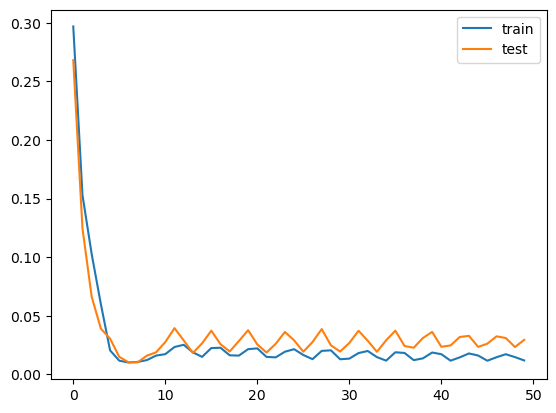

In [70]:
# plot history
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [71]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


14/14 [==============================] - 0s 1ms/step
Test RMSE: 0.033
